# Segmentación de Empleados para Decisiones de RRHH

---

**Módulo:** Analítica de RRHH — *People Analytics*  
**Autor:** Kléver Mera

---

**📊 Caso guía:**  
RRHH de una empresa mediana en Ecuador que busca **diseñar planes de capacitación y acciones de retención**. Hay heterogeneidad en perfiles (edad, área, antigüedad, desempeño, satisfacción, ausentismo, formación). Se requiere **segmentar empleados** para adaptar **beneficios, programas de formación y planes de carrera** y **monitorear KPIs** de clima y rotación.

> **💼 Qué obtendrás**  
> - Un **pipeline reproducible** de segmentación (preprocesamiento → K-Means → evaluación) listo para producción.
> - **EDA orientado a negocio**.
> - **Selección de K** con **KElbowVisualizer (k_elbow)**.
> - **Lectura de resultados** paso a paso con **insights** e **implicaciones**.
> - **Acciones diferenciadas** por clúster: formación, retención, movilidad interna y bienestar.
> - **Interpretación** con **Heatmap** de centroides y **PCA 2D**.
> - **Artefactos** (`preprocess.pkl`, `kmeans.pkl`) para etiquetar nuevos empleados.
> - **Plantillas ejecutivas**: perfiles por clúster (Top 2 / Low 2 features) y
> - **Conclusión General**. 🧭


## 🎯 Objetivo de negocio y reglas para elegir **K**
Elegimos **K** considerando **viabilidad operativa** y **métricas**:
- **Operativo**: segmentos accionables (p.ej., 3 a 6 grupos) y tamaños no triviales (≥ 5% de la plantilla).
- **Analítico**: Método del **codo** para definir el número de clusters en función de la inercia.
- **Contexto RRHH**: que cada clúster inspire **acciones diferenciadas** (formación, retención, movilidad interna, bienestar).

## 📋 Contenido del Dataset

El dataset contiene información sobre empleados y sus características. Estas incluyen tanto variables numéricas como categóricas. A continuación, se detallan las principales columnas:

**Variables numéricas**:
  - `edad`: Edad del empleado.
  - `cumplimiento_kpi`: Nivel de cumplimiento de indicadores clave de desempeño.
  - `puntaje_productividad`: Puntuación de productividad.
  - `puntaje_iniciativa`: Nivel de iniciativa del empleado.
  - `satisfaccion_laboral`: Nivel de satisfacción laboral (escala de 1 a 10).
  - `horas_capacitacion`: Horas de capacitación recibidas.
  - `puntaje_feedback_lider`: Calificación del feedback recibido de sus líderes.
  - `antiguedad`: Años de antigüedad en la empresa.
  - `promocion_ultimos_2_anos`: Indicador binario que señala si el empleado fue promovido en los últimos dos años (1: sí, 0: no).
    

**Variables categóricas**:
  - `genero`: Género del empleado (Masculino/Femenino).
  - `nivel_educativo`: Nivel educativo alcanzado (Secundaria, Licenciatura, Maestría, Doctorado).
  - `balance_trabajo_vida`: Nivel de equilibrio entre trabajo y vida personal (Bajo, Medio, Alto).
  - `evaluacion_liderazgo`: Evaluación del liderazgo recibido (Bajo, Medio, Alto).
  - `categoria_desempeno`: Clasificación general del desempeño (Bajo, Medio, Alto).

## 1. CARGA Y EXPLORACIÓN DE DATOS

In [1]:
import os, sys, json, joblib, platform, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
print("="*80)
print("ANÁLISIS DEL CONJUNTO DE DATOS DE EMPLEADOS")
print("="*80)
print("\n")
# carga del dataset
DATA_PATH = 'dataset_segmentacion_empleados.csv'
df = pd.read_csv(DATA_PATH)
display(df.head())

print(f"Shape del dataset: {df.shape}")


ANÁLISIS DEL CONJUNTO DE DATOS DE EMPLEADOS




,id_empleado,edad,genero,nivel_educativo,cumplimiento_kpi,puntaje_productividad,puntaje_iniciativa,satisfaccion_laboral,balance_trabajo_vida,horas_capacitacion,puntaje_feedback_lider,evaluacion_liderazgo,antiguedad,promocion_ultimos_2_anos,categoria_desempeno
0,E0001,50,Femenino,Licenciatura,72,76,90,10,Medio,46,1.3,Baja,2,1,Medio
1,E0002,36,Femenino,Licenciatura,59,72,100,2,Alto,8,1.5,Media,14,1,Alto
2,E0003,29,Masculino,Secundaria,60,73,75,10,Medio,9,3.6,Media,16,0,Alto
3,E0004,42,Femenino,Doctorado,90,58,61,5,Medio,7,2.4,Baja,13,0,Medio
4,E0005,40,Femenino,Maestría,90,84,44,6,Bajo,20,3.8,Media,15,0,Bajo


Shape del dataset: (1000, 15)


## 2. ANALISIS EXPLORATORIO DE DATOS

In [3]:
# Diccionario resumido
info = pd.DataFrame({
    "col": df.columns,
    "dtype": [str(t) for t in df.dtypes],
    "n_null": df.isna().sum().values,
    "n_unique": [df[c].nunique(dropna=True) for c in df.columns]
}).sort_values(["dtype", "n_unique"])
display(info.head(20))

,col,dtype,n_null,n_unique
10,puntaje_feedback_lider,float64,0,41
13,promocion_ultimos_2_anos,int64,0,2
7,satisfaccion_laboral,int64,0,10
12,antiguedad,int64,0,19
1,edad,int64,0,38
9,horas_capacitacion,int64,0,50
4,cumplimiento_kpi,int64,0,51
5,puntaje_productividad,int64,0,51
6,puntaje_iniciativa,int64,0,71
2,genero,object,0,3


### Salud de datos

In [4]:
print("Duplicados:", df.duplicated().sum())
display(df.isna().sum().sort_values(ascending=False).head(15))

# Resumen numérico
num_cols = [feat for feat in df.columns if df[feat].dtype != 'O']
if len(num_cols) > 0:
    display(df[num_cols].describe(percentiles=[.25,.5,.75]).T)

# Frecuencias de categóricas (top 8 columnas por vista)
for c in df.select_dtypes(include=['object']).columns[:8]:
    print(f"\n[categórica] {c}")
    display(df[c].value_counts(dropna=False).head(10))

Duplicados: 0


id_empleado                 0
edad                        0
genero                      0
nivel_educativo             0
cumplimiento_kpi            0
puntaje_productividad       0
puntaje_iniciativa          0
satisfaccion_laboral        0
balance_trabajo_vida        0
horas_capacitacion          0
puntaje_feedback_lider      0
evaluacion_liderazgo        0
antiguedad                  0
promocion_ultimos_2_anos    0
categoria_desempeno         0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
edad,1000.0,40.9470,11.160858,22.0,31.0,42.0,50.0,59.0
cumplimiento_kpi,1000.0,74.9920,14.974852,50.0,62.0,75.0,88.0,100.0
puntaje_productividad,1000.0,74.9570,14.409469,50.0,63.0,74.0,88.0,100.0
puntaje_iniciativa,1000.0,65.2130,20.422505,30.0,47.0,66.0,83.0,100.0
satisfaccion_laboral,1000.0,5.5640,2.886215,1.0,3.0,5.5,8.0,10.0
horas_capacitacion,1000.0,24.0590,14.470346,0.0,12.0,24.0,36.0,49.0
puntaje_feedback_lider,1000.0,2.9271,1.139691,1.0,1.9,2.9,3.9,5.0
antiguedad,1000.0,10.2820,5.502977,1.0,5.0,10.0,15.0,19.0
promocion_ultimos_2_anos,1000.0,0.2140,0.410332,0.0,0.0,0.0,0.0,1.0



[categórica] id_empleado


id_empleado
E1000    1
E0001    1
E0002    1
E0003    1
E0004    1
E0005    1
E0006    1
E0007    1
E0984    1
E0983    1
Name: count, dtype: int64


[categórica] genero


genero
Femenino     471
Masculino    434
Otro          95
Name: count, dtype: int64


[categórica] nivel_educativo


nivel_educativo
Licenciatura    385
Secundaria      294
Maestría        269
Doctorado        52
Name: count, dtype: int64


[categórica] balance_trabajo_vida


balance_trabajo_vida
Medio    492
Bajo     256
Alto     252
Name: count, dtype: int64


[categórica] evaluacion_liderazgo


evaluacion_liderazgo
Media    518
Baja     290
Alta     192
Name: count, dtype: int64


[categórica] categoria_desempeno


categoria_desempeno
Medio    383
Alto     309
Bajo     308
Name: count, dtype: int64

## Propósito y preguntas de negocio

In [5]:
# indicador de desempeño 'Bajo'
df['es_bajo'] = (df['categoria_desempeno'].astype(str).str.lower() == 'bajo').astype(int)

# Para algunos análisis por tramos de antigüedad (quintiles)
df['antiguedad_q'] = pd.qcut(df['antiguedad'], q=5, labels=[f"Q{i}" for i in range(1,6)]) 

1) **¿Qué género tiene peor desempeño promedio y menor cumplimiento de KPI?**

In [6]:
cols = ['puntaje_productividad','cumplimiento_kpi','puntaje_iniciativa',
        'satisfaccion_laboral','balance_trabajo_vida','horas_capacitacion']
out = (df.groupby('genero')[cols + ['es_bajo']]
         .mean(numeric_only=True)
         .sort_values('es_bajo', ascending=False))
display(out)

,puntaje_productividad,cumplimiento_kpi,puntaje_iniciativa,satisfaccion_laboral,horas_capacitacion,es_bajo
genero,,,,,,
Otro,75.063158,76.726316,64.294737,5.800000,27.000000,0.368421
Femenino,74.749469,74.430998,64.855626,5.380042,23.639066,0.318471
Masculino,75.158986,75.221198,65.801843,5.711982,23.870968,0.283410


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* **KPI promedio más bajo:** Femenino (≈74.43); luego Masculino (≈75.22) y Otro (≈76.73).
* **Productividad promedio más baja:** Femenino (≈74.75) vs Masculino (≈75.16) y Otro (≈75.06).
* **Mayor proporción de “bajo desempeño” (`es_bajo`):** grupo **Otro** (\~0.37), luego **Femenino** (\~0.32) y **Masculino** el menor (\~0.28).
* **Satisfacción laboral:** más baja en **Femenino** (\~5.38).
* **Horas de capacitación:** más altas en **Otro** (\~27), similares en Femenino/Masculino (\~23.6–23.9).

**Cómo leer:**

* “**Peor desempeño promedio**” puede leerse con `es_bajo` (mayor = peor) y/o productividad media (menor = peor).
* Para **KPI**, el **peor cumplimiento** es **Femenino**.
* El grupo **Otro** combina KPI alto con `es_bajo` alto → posible **polarización** (subgrupos) y/o **n tamaño pequeño**; interpretar con cautela.
* Diferencias son **moderadas**, conviene validar con **tamaños de muestra** y/o pruebas de significancia antes de decisiones estructurales.

**Implicaciones para RRHH:**

* **Femenino:** foco en **mejorar cumplimiento de KPI** y **satisfacción**: revisión de metas/recursos, coaching de desempeño, mentoring, reconocimiento y ajustes de carga/horarios.
* **Masculino:** mantener prácticas actuales (mejor `es_bajo`) con **reconocimiento** y oportunidades de desarrollo para sostener resultados.
* **Otro:** hacer **diagnóstico individual** (muestra y roles), reforzar **acompañamiento 1:1** y asegurar prácticas **inclusivas**; si el n es pequeño, tratar como **casos** más que como segmento.


2) **¿Qué nivel_educativo concentra mayor proporción de desempeño bajo?**

In [7]:
prop_bajo_x_edu = (df.groupby('nivel_educativo')['es_bajo']
                     .mean()
                     .sort_values(ascending=False)
                     .rename('prop_des_bajo'))
display(prop_bajo_x_edu.to_frame())

,prop_des_bajo
nivel_educativo,
Doctorado,0.365385
Secundaria,0.336735
Licenciatura,0.306494
Maestría,0.267658


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* Mayor proporción de **desempeño bajo** en **Doctorado (0.365)** y **Secundaria (0.337)**.
* Menor proporción en **Maestría (0.268)**; **Licenciatura** queda intermedio (0.306).
* Brecha aprox. **10 p.p.** entre Doctorado y Maestría.

**Cómo leer:**

* El indicador es una **proporción** (`mean` de `es_bajo`), no el número de personas.
* Puede estar influido por **mezcla de roles**, **antigüedad** y **tamaños de muestra** distintos por nivel educativo. Ideal contrastar con conteos y, si es posible, un **modelo ajustado** (p. ej., logística controlando por puesto/área/antigüedad).

**Implicaciones para RRHH:**

* **Doctorado:** posible **desalineación/infrautilización** del perfil (overqualification) o **métricas no ajustadas** al tipo de rol. Acciones: revisión de **job-fit**, asignación a proyectos de mayor complejidad/impacto, ajuste de KPIs y responsabilidades (innovación, mentoría técnica).
* **Secundaria:** refuerza **capacitación técnica y on-the-job**, estandariza procesos y supervisión, rutas claras de **upskilling**.
* **Licenciatura:** mantenimiento con **coaching focal** en los equipos con mayor proporción de bajo desempeño.
* **Maestría:** sostener prácticas actuales y activar **planes de carrera** para evitar estancamiento.


3) **¿Cómo varían las horas de capacitación según evaluación de liderazgo?**

In [8]:
cap_por_liderazgo = (df.groupby('evaluacion_liderazgo')['horas_capacitacion']
                       .mean()
                       .sort_values(ascending=False)
                       .rename('horas_capacitacion_prom'))
display(cap_por_liderazgo.to_frame())


,horas_capacitacion_prom
evaluacion_liderazgo,
Media,24.909266
Alta,23.937500
Baja,22.620690


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* Promedio de **horas de capacitación** por evaluación de liderazgo: **Media 24.9 > Alta 23.9 > Baja 22.6**.
* Brecha moderada entre extremos (**≈2.3 h**); no es grande pero sí consistente.

**Cómo leer:**

* Son **promedios**; falta considerar **tamaños de muestra y dispersión**.
* Las horas reflejan **cantidad**, no **calidad ni efectividad** de la formación.
* El patrón sugiere que quienes tienen **liderazgo “Baja”** reciben **menos horas** que “Media/Alta”, lo cual podría **no** estar alineado con un enfoque de cierre de brechas.

**Implicaciones para RRHH:**

* Establecer un **mínimo garantizado** y un **itinerario intensivo** para “Baja” (p. ej., habilidades de feedback, comunicación, conducción de 1:1), con **coaching** y seguimiento mensual.
* Mantener a “Media” con programas de **aceleración** (proyectos retadores + formación aplicada) para moverlos a “Alta”.
* Para “Alta”, priorizar **programas avanzados** y **rol de mentores** (parte de sus horas orientadas a enseñar).


4) **¿Qué tramos de antigüedad (quintiles) muestran mayor desempeño bajo y menor KPI?**

In [9]:
by_ant = (df.groupby('antiguedad_q')[['es_bajo','cumplimiento_kpi','puntaje_productividad']]
            .mean(numeric_only=True)
            .sort_index())
display(by_ant)


,es_bajo,cumplimiento_kpi,puntaje_productividad
antiguedad_q,,,
Q1,0.351485,74.529703,75.297030
Q2,0.307692,74.427885,75.408654
Q3,0.264000,74.484000,74.644000
Q4,0.300578,75.994220,74.161850
Q5,0.329341,75.976048,75.275449


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* **Mayor proporción de “bajo desempeño”** en **Q1** (0.351) y **Q5** (0.329); **menor** en **Q3** (0.264).
* **KPI más bajo** en **Q2** (74.43) y cercano en **Q1**; **KPI más alto** en **Q4–Q5** (\~76).
* **Productividad** cae en **Q4** (74.16) pese al KPI alto; Q1–Q2 y Q5 rondan \~75.3.

**Cómo leer:**

* Quintiles por **antigüedad** (Q1 = menor, Q5 = mayor).
* `es_bajo` es **proporción**, no conteo. Diferencias son **moderadas**; conviene revisar **tamaños de muestra** y, si es posible, significancia/IC y mezcla de **roles/áreas**.

**Implicaciones para RRHH:**

* **Q1 (ingreso reciente):** fortalecer **onboarding y mentoring**; metas de rampa y feedback semanal para reducir “bajo”.
* **Q2 (tempranos):** foco en **claridad de expectativas y coaching en KPI**; probablemente aún en rampa.
* **Q3 (medio):** **sweet spot**; asignar **proyectos críticos** y rol de **mentores** para multiplicar impacto.
* **Q4 (alto):** aunque el KPI sube, la **productividad baja** → **upskilling**, revisión de **procesos/carga** y objetivos de eficiencia.
* **Q5 (muy alto):** repunta el “bajo desempeño” → atender **obsolescencia/burnout** con **rotación lateral, reskilling, refresco de rol** y planes de **sucesión** + reconocimiento.


5) **¿Qué categoría de desempeño recibe más horas de capacitación (en promedio)?**

In [10]:
cap_por_desempeno = (df.groupby('categoria_desempeno')['horas_capacitacion']
                       .mean()
                       .sort_values(ascending=False)
                       .rename('horas_capacitacion_prom'))
display(cap_por_desempeno.to_frame())


,horas_capacitacion_prom
categoria_desempeno,
Medio,24.762402
Bajo,23.737013
Alto,23.508091


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* **Más horas de capacitación (promedio):** **Desempeño Medio** (\~24.76) > **Bajo** (\~23.74) > **Alto** (\~23.51).
* La **brecha** entre “Medio” y “Alto” es **pequeña** (\~1.25 h).

**Cómo leer:**

* Son **promedios** de horas (cantidad, no calidad/impacto).
* La mayor carga en “Medio” sugiere programas de **aceleración** para subirlos a **"Alto"** los “Altos” podrían capacitarse menos por **prioridades operativas**.
* Validar con **tamaños de muestra/dispersiones** e idealmente contrastar con **ANOVA/Kruskal** y **pre–post** de desempeño.

**Implicaciones para RRHH:**

* **Bajo:** establecer **mínimo garantizado** + plan **remedial** ligado a brechas de KPI (coaching, prácticas guiadas, seguimiento quincenal).
* **Medio:** mantener y afinar **programas de aceleración** (aplicación en proyecto real) para convertirlos en **Alto**.
* **Alto:** priorizar **formación avanzada** y **rol de mentores** (parte de sus horas “enseñando”); medir **ROI** por transferencia al equipo.


6) **¿Cómo se distribuye la categoría de desempeño por nivel educativo?**

In [11]:
ct1 = pd.crosstab(df['nivel_educativo'], df['categoria_desempeno'], normalize='index')
display(ct1.round(3))


categoria_desempeno,Alto,Bajo,Medio
nivel_educativo,,,
Doctorado,0.288,0.365,0.346
Licenciatura,0.304,0.306,0.390
Maestría,0.301,0.268,0.431
Secundaria,0.327,0.337,0.337


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* **Mayor “Bajo”** en **Doctorado (0.365)** y **Secundaria (0.337)**.
* **Menor “Bajo”** en **Maestría (0.268)**.
* **“Medio”** destaca en **Maestría (0.431)** y **Licenciatura (0.390)**.
* **“Alto”** es similar entre niveles (0.288–0.327), ligeramente mayor en **Secundaria (0.327)**.

**Cómo leer:**

* Tabla **normalizada por fila**: son **proporciones dentro de cada nivel educativo**, no conteos; conviene ver el **tamaño de muestra** por nivel.
* Las diferencias pueden reflejar **mix de roles/antigüedad**; ideal contrastar con KPI/productividad y ajustar por área/tenencia antes de concluir causalidad.

**Implicaciones para RRHH:**

* **Doctorado:** señales de **desalineación/overqualification** → revisar **job-fit y KPIs**, asignar **proyectos de alto impacto/innovación**, rol de **mentor técnico**.
* **Secundaria:** distribución pareja pero con “Bajo” elevado → **upskilling** técnico, **SOPs** claros, supervisión cercana y rutas a certificaciones.
* **Licenciatura:** alta concentración en “Medio” → **programas de aceleración** (proyectos aplicados + coaching) para migrar a “Alto”.
* **Maestría:** buen perfil (bajo “Bajo”, alto “Medio”) → sostener y **empujar a “Alto”** con proyectos estratégicos y pipeline de liderazgo.
* **Transversal:** monitorear **transiciones** entre categorías por nivel y validar diferencias con **pruebas estadísticas** antes de políticas globales.


7) **¿Cómo se distribuye la categoría de desempeño por género?**

In [12]:
ct2 = pd.crosstab(df['genero'], df['categoria_desempeno'], normalize='index')
display(ct2.round(3))


categoria_desempeno,Alto,Bajo,Medio
genero,,,
Femenino,0.306,0.318,0.376
Masculino,0.318,0.283,0.399
Otro,0.284,0.368,0.347


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* **Masculino**: mayor proporción en **Medio** (0.399) y **Alto** (0.318); **menor “Bajo”** (0.283).
* **Femenino**: **“Bajo”** más alto que Masculino (0.318 vs 0.283) y **Alto** algo menor (0.306); “Medio” 0.376.
* **Otro**: **“Bajo”** más alto (0.368) y **“Alto”** más bajo (0.284); “Medio” 0.347.

**Cómo leer:**

* Son **proporciones dentro de cada género** (tabla normalizada por fila), no conteos absolutos.
* Diferencias son **moderadas**; pueden deberse a **mezclas de rol/antigüedad/área**. Conviene contrastar con tamaños de muestra y probar **chi-cuadrado** para independencia.

**Implicaciones para RRHH:**

* **Femenino:** reforzar **coaching de desempeño y claridad de KPIs**, revisar cargas/recursos y asegurar **acceso equitativo** a formación/mentoría y reconocimiento.
* **Masculino:** **mantener** prácticas actuales; monitorear sesgos (p. ej., asignación de oportunidades) y promover **equidad** en desarrollo.
* **Otro:** dada la mayor proporción en “Bajo”, aplicar **acompañamiento 1:1**, revisar **job-fit** y garantizar **prácticas inclusivas**; si el n es pequeño, tratar como **casos individuales** más que políticas generales.


8) **¿Qué combinación género × evaluación de liderazgo concentra más desempeño bajo?**

In [13]:
ct3 = pd.crosstab(df['genero'], df['evaluacion_liderazgo'], values=df['es_bajo'],
                  aggfunc='mean').fillna(0)
display(ct3.round(3).sort_values(by=list(ct3.columns), ascending=False))


evaluacion_liderazgo,Alta,Baja,Media
genero,,,
Otro,0.333,0.308,0.422
Masculino,0.318,0.292,0.265
Femenino,0.288,0.340,0.316


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* Mayor proporción de **desempeño bajo** en **“Otro–Liderazgo Medio” (0.422)**.
* **Femenino**: patrón esperado → **Baja (0.340) > Media (0.316) > Alta (0.288)**.
* **Masculino**: patrón inverso → **Alta (0.318) > Baja (0.292) > Media (0.265)**.
* En “Otro”, **Media (0.422)** y **Alta (0.333)** superan a **Baja (0.308)**.

**Cómo leer:**

* Cada celda es la **proporción** de `es_bajo` dentro de la combinación (no conteos).
* Posibles **efectos de tamaño de muestra** (especialmente en “Otro”) y **mezcla de roles/antigüedad/áreas**; no implica causalidad.
* Recomendado contrastar con **conteos**, e idealmente un **modelo logístico** con interacción `género × evaluación_liderazgo` para validar significancia y descartar **paradojas de mezcla**.

**Implicaciones para RRHH:**

* **Femenino–Baja**: priorizar **mejora de liderazgo** (feedback, apoyo, asignación de recursos) y **mentoría** para el equipo.
* **Masculino–Alta**: investigar **calibración de metas/carga** y posibles **sesgos de evaluación**; revisar **equidad de oportunidades** y reconocimiento.
* **Otro–Media**: tratamiento **caso a caso** (probable n pequeño); asegurar **prácticas inclusivas** y acompañamiento 1:1.
* **Transversal**: diseñar un plan de **desarrollo para líderes “Medios/Bajos”** y un **mecanismo de calibración** de desempeño entre equipos; monitorear trimestralmente estas combinaciones como **segmentos de riesgo**.


9) **¿Qué combinación nivel educativo × evaluación de liderazgo tiene mayor proporción de desempeño bajo?**

In [14]:
ct4 = pd.crosstab(df['nivel_educativo'], df['evaluacion_liderazgo'], values=df['es_bajo'],
                  aggfunc='mean').fillna(0)
display(ct4.round(3).sort_values(by=list(ct4.columns), ascending=False))


evaluacion_liderazgo,Alta,Baja,Media
nivel_educativo,,,
Maestría,0.346,0.353,0.201
Licenciatura,0.314,0.269,0.327
Secundaria,0.281,0.360,0.344
Doctorado,0.231,0.294,0.500


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* Mayor proporción de **desempeño bajo**: **Doctorado–Liderazgo “Media” (0.500)**.
* Otros focos elevados: **Secundaria–“Baja” (0.360)** y **Maestría–“Baja” (0.353)**.
* **Menor proporción**: **Maestría–“Media” (0.201)** y **Doctorado–“Alta” (0.231)**.
* En **Licenciatura**, el mayor valor está en **“Media” (0.327)**, no en “Baja”.

**Cómo leer:**

* Cada celda es la **proporción de `es_bajo`** dentro de esa combinación (no el conteo de personas).
* Posibles efectos de **tamaño de muestra** y **mezcla de roles/antigüedad/áreas**; interpretar con cautela.
* Útil validar con un **modelo logístico con interacción** (nivel×liderazgo), más conteos y **IC** para confirmar diferencias.

**Implicaciones para RRHH:**

* **Doctorado–“Media” (0.500):** alto riesgo; revisar **job-fit** y **KPIs** (posible infrautilización). Asignar **proyectos técnicos/innovación**, pares/líderes con **expertise** y mayor **autonomía**.
* **Secundaria–“Baja” (0.360):** reforzar **SOPs**, **coaching del supervisor** y **upskilling** básico; seguimiento semanal de metas.
* **Maestría–“Baja” (0.353):** plan de **mejora de liderazgo** (feedback, claridad de objetivos) para capturar el potencial de este nivel.
* **Maestría–“Media” (0.201):** combinación **protectora**; documentar y **replicar** prácticas del equipo/líder.
* **Licenciatura–“Media” (0.327):** investigar **calibración de evaluaciones** y carga/objetivos; puede haber **desalineación** entre expectativas y rol.
* **Transversal:** priorizar intervenciones por **calor de riesgo** (p. ej., Doctorado–Media y Secundaria–Baja primero) y monitorear trimestralmente estos cruces.


10) **¿Cuál es el promedio de satisfacción por nivel educativo × evaluación de liderazgo?**

In [15]:
pv1 = pd.pivot_table(df, values='satisfaccion_laboral',
                     index='nivel_educativo', columns='evaluacion_liderazgo',
                     aggfunc='mean', margins=True)
display(pv1.round(2))


evaluacion_liderazgo,Alta,Baja,Media,All
nivel_educativo,,,,
Doctorado,5.38,6.65,5.36,5.79
Licenciatura,5.63,5.57,5.54,5.57
Maestría,5.83,5.28,5.73,5.64
Secundaria,5.88,5.45,5.30,5.46
All,5.74,5.53,5.52,5.56


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* En general, la satisfacción es **mayor con liderazgo “Alta”** (promedio global 5.74) que con **“Media” (5.52)** o **“Baja” (5.53)**.
* Por nivel:

  * **Secundaria:** Alta **5.88** > Baja **5.45** > Media **5.30** (brecha marcada).
  * **Maestría:** Alta **5.83** > Media **5.73** >> Baja **5.28**.
  * **Licenciatura:** valores **parejos** (5.54–5.63).
  * **Doctorado:** patrón atípico: **Baja 6.65** > Alta 5.38 ≈ Media 5.36 (posible n pequeño/mezcla de roles).

**Cómo leer:**

* Son **promedios**, no distribuciones; verificar **tamaño de muestra** e **intervalos de confianza** (ANOVA/Kruskal) antes de inferir causalidad.
* El efecto del liderazgo **interactúa** con nivel educativo (no es uniforme). El caso de **Doctorado–Baja** sugiere **precaución** (muestra, job-fit, naturaleza de roles).

**Implicaciones para RRHH:**

* **Prioritario:** elevar líderes de **“Media/Baja” a “Alta”** en **Secundaria y Maestría** (ganancias potenciales de \~0.4–0.6 puntos).
* **Licenciatura:** mantener prácticas; micro-mejoras de liderazgo podrían tener **retorno limitado** (brecha pequeña).
* **Doctorado:** hacer **deep-dive cualitativo** (job-fit, autonomía, tipo de proyecto, tamaño muestral) y calibrar estilo de liderazgo (más **autonomía/impacto**).
* **Transversal:** programa de **desarrollo de líderes** (feedback efectivo, claridad de objetivos, autonomía) y **monitoreo trimestral** por cruce **nivel × liderazgo** para medir mejoras en satisfacción.


11) **¿Qué combinación de nivel educativo × género presenta mayor proporción de desempeño bajo?**

In [16]:
# Booleano para pivot (ya lo creamos como 'es_bajo')
pv3 = pd.pivot_table(df, values='es_bajo',
                     index='nivel_educativo', columns='genero',
                     aggfunc='mean', margins=True)
display(pv3.round(3))


genero,Femenino,Masculino,Otro,All
nivel_educativo,,,,
Doctorado,0.385,0.318,0.500,0.365
Licenciatura,0.324,0.295,0.258,0.306
Maestría,0.250,0.265,0.375,0.268
Secundaria,0.368,0.278,0.444,0.337
All,0.318,0.283,0.368,0.308


### 🔎 Hallazgos e implicaciones

**Qué se ve:**

* **Riesgo más alto:** **Doctorado–Otro (0.500)** y **Secundaria–Otro (0.444)**.
* **Femenino** con mayor “bajo” en **Doctorado (0.385)** y **Secundaria (0.368)**.
* **Riesgo más bajo:** **Maestría–Femenino (0.250)** y **Maestría–Masculino (0.265)**; también bajo **Licenciatura–Otro (0.258)**.
* Promedios globales por género: **Masculino 0.283 < Femenino 0.318 < Otro 0.368**.

**Cómo leer:**

* Cada celda es la **proporción** de `es_bajo` en esa combinación (no conteos).
* Posibles efectos de **tamaño muestral** (especialmente en “Otro”) y **mezcla de roles/antigüedad/áreas**; no implica causalidad.
* Recomendable verificar **conteos** e implementar un **modelo logístico con interacción** (nivel×género) para confirmar diferencias.

**Implicaciones para RRHH:**

* **Doctorado–Otro / Secundaria–Otro:** tratamiento **caso a caso** (probable n pequeño), asegurar **inclusión y job-fit**, acompañamiento 1:1 y revisión de **KPIs**.
* **Femenino–Doctorado / Femenino–Secundaria:** reforzar **coaching de desempeño**, acceso a **mentoría/recursos** y calibración de metas.
* **Maestría (F y M):** combinación **protectora**; **replicar prácticas** (liderazgo, diseño de rol) y convertir en **mentores**.
* **Licenciatura–Otro (positivo):** investigar qué prácticas explican el mejor resultado y **escalarlas**.
* **Transversal:** priorizar intervenciones según “mapa de riesgo” anterior y monitorear **pre–post** por subgrupo trimestralmente.


## 3. FEATURE ENGINEERING

In [17]:
df = pd.read_csv(DATA_PATH)
num_cols = [feat for feat in df.columns if df[feat].dtype != 'O']
features = df[num_cols]

# Pipeline de etandarización
preprocess = Pipeline(
    [('scaler', StandardScaler())]
)
scaled_features = preprocess.fit_transform(features)

# PCA - dos componentes principales
features_2d = PCA(n_components=2).fit_transform(scaled_features)


### Método del codo

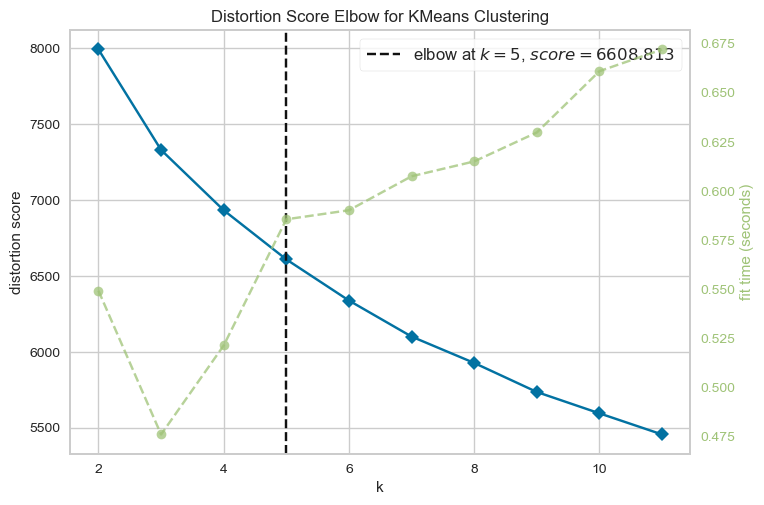

In [18]:
# Calcular la inercia para diferentes cantidades de clústeres
from yellowbrick.cluster import KElbowVisualizer

K_MIN, K_MAX = 2, 12
modelo = KMeans(init='k-means++', n_init=100, max_iter=1000, random_state=RANDOM_STATE)
visual = KElbowVisualizer(modelo, k=(K_MIN, K_MAX))

visual.fit(scaled_features)
visual.show();

In [19]:
k_elbow = visual.elbow_value_
print(f"El valor de k con el método del codo: {k_elbow}")

El valor de k con el método del codo: 5


In [20]:
# Models
kmeans = KMeans(n_clusters=k_elbow, init='k-means++', n_init=100, max_iter=1000, random_state=RANDOM_STATE)

# ajustar el modelo y predecir la asignacion de clusters
km_clusters = kmeans.fit_predict(scaled_features)
km_clusters[:10]

array([0, 0, 3, 3, 1, 3, 2, 3, 3, 0], dtype=int32)

In [21]:
data_kmeans = df.copy()
data_kmeans['cluster'] = km_clusters
data_kmeans['cluster'].value_counts()

cluster
0    213
4    202
3    200
2    196
1    189
Name: count, dtype: int64

In [22]:
# función para plot de los clusters
def plot_clusters(samples, clusters):
    col_dic = {0: 'blue', 1: 'green', 2: 'orange', 3: 'yellow', 4: 'red'}
    mrk_dic = {0: '*', 1: 'x', 2: '+', 3: '.', 4: '^'}
    colors = [col_dic[i] for i in clusters]
    markers = [mrk_dic[j] for j in clusters]
    for sample in range(len(clusters)):
        plt.scatter(samples[sample][0], samples[sample][1], color=colors[sample], marker=markers[sample], s=100)
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.title("Clusters")
    plt.show()

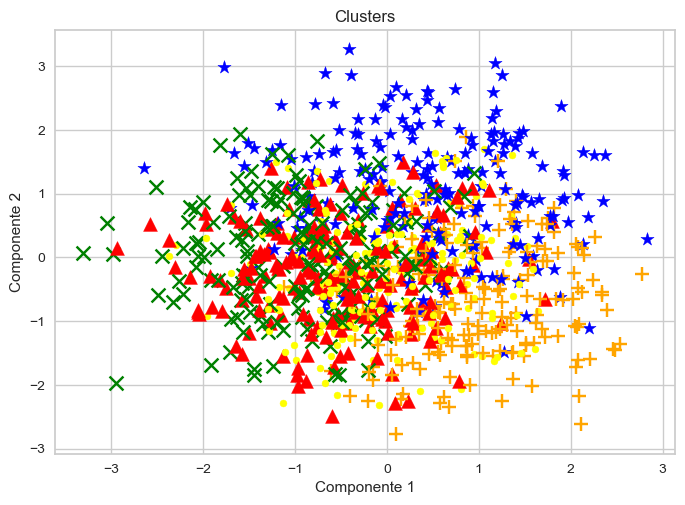

In [23]:
# Plot de clusters con 2 componentes de PCA
plot_clusters(features_2d, km_clusters)   

### 🔎 Análisis del gráfico de dos componentes PCA por cluster

**Contexto:** Proyección PCA a 2 componentes de los 5 clústeres K-Means. Colores/markers:
0=azul(\*) **(n=213)**, 1=verde(x) **(n=189)**, 2=naranja(+) **(n=196)**, 3=amarillo(.) **(n=200)**, 4=rojo(^) **(n=202)**.

1. **Separación y solapamiento**

* Existe un **núcleo central con solapamiento** (perfiles que comparten rasgos), pero se observan **direcciones preferentes** por clúster, lo que confirma que la segmentación captura patrones diferenciales útiles para RRHH.

2. **Forma y localización por clúster**

* **C0 Azul (213, el mayor):** concentrado en cuadrante superior-derecho, con mayor varianza en la Componente 2 → grupo dominante y **bien diferenciado** en esa dimensión.
* **C1 Verde (189, el menor):** compacto en zona centro-izquierda → **alta homogeneidad**; nicho específico y estable.
* **C2 Naranja (196):** elongado hacia la derecha (Componente 1) → **perfil diferenciado** en variables asociadas a esa dimensión (p.ej., desempeño/experiencia).
* **C3 Amarillo (200):** más **difuso/mixto** alrededor del centro → perfil **intermedio o de transición**.
* **C4 Rojo (202):** concentración centro-inferior con dispersión vertical moderada → **rasgos atípicos/específicos** frente al resto.

3. **Implicaciones operativas (tamaño + definición)**

* **Escala (impacto rápido):** C0, C4 y C3 (los más numerosos) para planes estandarizados: desarrollo/actualización/acompañamiento.
* **Selectividad (valor crítico):** C2 para acciones de reconocimiento/retención focalizada.
* **Corrección fina:** C1, por su menor tamaño y homogeneidad, permite **intervenciones precisas** (engagement/coaching) y medición clara de impacto.

4. **Conclusión ejecutiva**
   La estructura es **equilibrada** (diferencias de tamaño ≤24) y muestra **segmentos accionables**: un grupo dominante bien separado (C0), dos grupos masivos para política escala (C3, C4), un segmento diferenciado para retención (C2) y un nicho homogéneo para ajustes finos (C1). La gráfica respalda activar **estrategias diferenciadas por clúster** y priorizar según **tamaño x claridad de separación**.


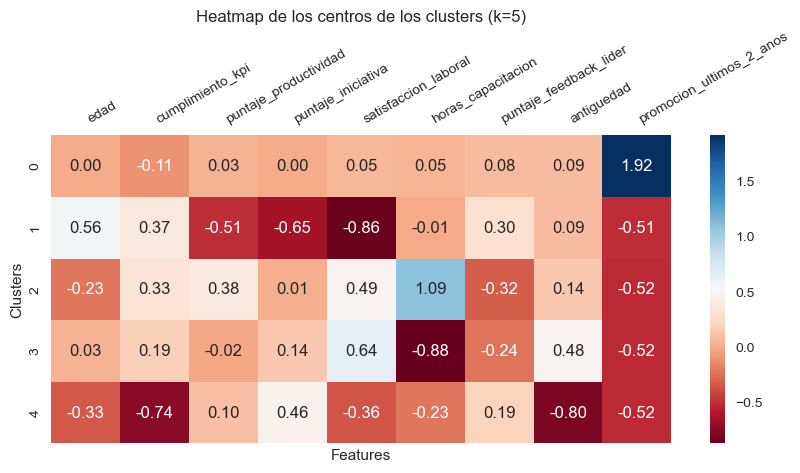

In [24]:
# heatmap de los centroides
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)

plt.figure(figsize=(10, 4))
sns.heatmap(centroides,
           annot=True,
           fmt='.2f',
           cmap='RdBu').xaxis.tick_top()
plt.xticks(rotation=30, ha='left')
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.title("Heatmap de los centros de los clusters (k=5)")
plt.show()

In [25]:
#top_low_features(centroides)
def top_low_features(z_row, top=2, low=2):
    s = z_row.sort_values(ascending=False)
    return {'top': s.index[:top].tolist(), 'low': s.index[-low:].tolist()}

summary_profiles = {int(cl): top_low_features(centroides.loc[cl]) for cl in range(centroides.shape[0])}
summary_profiles

{0: {'top': ['promocion_ultimos_2_anos', 'antiguedad'],
  'low': ['edad', 'cumplimiento_kpi']},
 1: {'top': ['edad', 'cumplimiento_kpi'],
  'low': ['puntaje_iniciativa', 'satisfaccion_laboral']},
 2: {'top': ['horas_capacitacion', 'satisfaccion_laboral'],
  'low': ['puntaje_feedback_lider', 'promocion_ultimos_2_anos']},
 3: {'top': ['satisfaccion_laboral', 'antiguedad'],
  'low': ['promocion_ultimos_2_anos', 'horas_capacitacion']},
 4: {'top': ['puntaje_iniciativa', 'puntaje_feedback_lider'],
  'low': ['cumplimiento_kpi', 'antiguedad']}}

## 4. PERFILAMIENTO EJECUTIVO POR CLUSTER

🔵 **Cluster 0 – “Talento con Potencial de Ascenso”**

- **Top features**: promocion_ultimos_2_anos, antiguedad
- **Low features**: edad, cumplimiento_kpi

- **Interpretación**: Grupo de empleados con fuerte historial de promociones recientes y experiencia consolidada, aunque con edad promedio y cumplimiento de KPIs más bajos. Representa un talento que la organización ya ha promovido, con potencial de seguir avanzando.

- **Conclusión**: Perfil clave para planes de desarrollo acelerado. Mantener motivación e impulsar proyectos de alto impacto.

- **Acciones recomendadas**:
>   - Diseñar planes de movilidad interna y mentoring para sostener la proyección de carrera.
>   - Asignar roles estratégicos que capitalicen su experiencia acumulada.


---
🟠 **Cluster 1 – “Juventud con Desafíos de Compromiso”**

- **Top features**: edad, cumplimiento_kpi
- **Low features**: puntaje_iniciativa, satisfaccion_laboral

- **Interpretación**: Empleados relativamente jóvenes, con cumplimiento aceptable en métricas de desempeño, pero con bajos niveles de iniciativa y satisfacción laboral. Pueden estar cumpliendo lo mínimo esperado sin compromiso adicional.

- **Conclusión**: Perfil en riesgo de desmotivación. Necesita programas de engagement y coaching.

- **Acciones recomendadas**:
>   - Implementar programas de bienestar y escucha activa.
>   - Desarrollar entrenamientos en liderazgo personal y proactividad.


---
🟢 **Cluster 2 – “Aprendices Motivados”**

- **Top features**: horas_capacitacion, satisfaccion_laboral
- **Low features**: puntaje_feedback_lider, promocion_ultimos_2_anos

- **Interpretación**: Grupo que invierte en capacitación y muestra buena satisfacción laboral, aunque con baja retroalimentación positiva del líder y sin promociones recientes.

- **Conclusión**: Perfil con motivación por aprender, pero que necesita reconocimiento y oportunidades de crecimiento.

- **Acciones recomendadas**:
>  - Fortalecer la calidad del feedback de líderes.
>  - Crear programas de reconocimiento visibles y accesibles.

---
🔵 **Cluster 3 – “Comprometidos pero Estancados”**

- **Top features**: satisfaccion_laboral, antiguedad
- **Low features**: promocion_ultimos_2_anos, horas_capacitacion

- **Interpretación**: Empleados con alta satisfacción y amplia permanencia en la empresa, pero con escasas promociones y poca capacitación. Son leales y comprometidos, pero con riesgo de estancamiento profesional.

- **Conclusión**: Perfil estable, pero vulnerable a la desactualización. Requiere revitalización de carrera.

- **Acciones recomendadas**:
>   - Diseñar planes de actualización continua.
>   - Promover la rotación horizontal para ampliar habilidades.

---
🔴 **Cluster 4 – “Críticos de Gestión”**

- **Top features**: puntaje_iniciativa, puntaje_feedback_lider
- **Low features**: cumplimiento_kpi, antiguedad

- **Interpretación**: Grupo con altos niveles de iniciativa y buen feedback de líderes, pero con bajo cumplimiento de KPIs y menor antigüedad. Representan colaboradores con alto potencial, aún en etapa de consolidación.

- **Conclusión**: Perfil emergente con energía y liderazgo natural, pero que necesita consolidar su desempeño en resultados cuantitativos.

- **Acciones recomendadas**:
>  - Entrenar en gestión del tiempo y enfoque en objetivos.
>  - Acompañamiento cercano para alinear energía con resultados.

### 📈 **Conclusión General**

La organización cuenta con una diversidad de perfiles que requieren estrategias diferenciadas. Destacan los clusters 0 y 2 como perfiles altamente aprovechables en términos de proyección y motivación. Los clusters 1 y 3 presentan oportunidades de mejora en compromiso y actualización, y deben ser reforzados con programas de acompañamiento y desarrollo. Finalmente, el cluster 4 representa un potencial emergente que necesita consolidación de resultados.

Una correcta segmentación y activación de planes por cluster permitirá aumentar la eficiencia global en la gestión de talento, optimizando recursos de RRHH y elevando los indicadores de desempeño organizacional.

### 🚀 Producción: artefactos y función de inferencia
Se guardan `preprocess.pkl` y `kmeans.pkl` y se expone función de inferencia segura con validación de esquema.


In [26]:
ARTIFACTS_DIR = './artifacts'

import joblib, platform
joblib.dump(preprocess, f'{ARTIFACTS_DIR}/preprocess.pkl')
joblib.dump(kmeans,    f'{ARTIFACTS_DIR}/kmeans.pkl')

['./artifacts/kmeans.pkl']